## Import libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

## Fetch Data

In [ ]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'

try:
    raw_data = yf.download(tickers, start=start_date, end=end_date)
    print('Data fetched successfully!')
except Exception as e:
    print(f'Error fetching data: {e}')
    raise

raw_data.to_csv('financial_data.csv')

df = None
for header_try in ([0,1,2], [0,1], [0]):
    try:
        df = pd.read_csv('financial_data.csv', index_col=0, parse_dates=True, header=header_try)
        print(f'Read CSV with header={header_try}')
        break
    except Exception:
        df = None

if df is None:
    print('Falling back to read without headers')
    df = pd.read_csv('financial_data.csv', header=None)

prefs = ['adj close', 'adj', 'adjusted', 'close', 'price']
def flatten_col(col):
    if isinstance(col, tuple):
        parts = [str(x) for x in col if (x is not None and str(x).strip() != '')]
        return ' '.join(parts).lower()
    return str(col).lower()

adj = None
if isinstance(df.columns, pd.MultiIndex):
    candidates = [col for col in df.columns if any(tok in flatten_col(col) for tok in prefs)]
    if candidates:
        adj = df[candidates]
    else:
        ticker_map = {}
        for t in tickers:
            matches = [col for col in df.columns if any(str(x).upper() == t.upper() for x in col)]
            if matches:
                chosen = None
                for m in matches:
                    if any(tok in flatten_col(m) for tok in ['close','price','adj']):
                        chosen = m
                        break
                if chosen is None:
                    chosen = matches[0]
                ticker_map[t.upper()] = chosen
        if ticker_map:
            adj = df[list(ticker_map.values())]
            adj.columns = [k for k in ticker_map.keys()]
        else:
            top_level = [str(x).lower() for x in df.columns.levels[0]]
            fallback_tokens = ['close', 'price']
            if any(tok in ' '.join(top_level) for tok in fallback_tokens):
                candidates = [col for col in df.columns if str(col[0]).lower() in fallback_tokens]
                if candidates:
                    adj = df[candidates]

    if adj is None:
        raise KeyError("Couldn't locate 'Adj Close' or any close-like field in the downloaded data columns")
else:
    cols = list(df.columns)
    candidates = [c for c in cols if any(tok in str(c).lower() for tok in prefs)]
    if candidates:
        adj = df[candidates]
    else:
        if any(str(c).upper() in [t.upper() for t in tickers] for c in cols):
            adj = df[[c for c in cols if str(c).upper() in [t.upper() for t in tickers]]]
        else:
            adj = df

if isinstance(adj, pd.Series):
    adj = adj.to_frame()

adj.columns = [str(c).upper() for c in adj.columns]
requested = [t.upper() for t in tickers]
available = [c for c in requested if c in adj.columns]
if not available and len(adj.columns) > 0:
    available = list(adj.columns)

adj = adj.reindex(columns=available)
adj.to_csv('adj_close.csv')

data = adj
print('Adj Close extraction complete. Columns:', list(data.columns))

/tmp/ipykernel_4388/2574668056.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed


Data fetched successfully!
Read CSV with header=[0, 1, 2]
Adj Close extraction complete. Columns: ["('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')", "('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')", "('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2')"]


## Data Cleaning and preparation

In [ ]:
if isinstance(data, pd.Series):
    data = data.to_frame()
elif not isinstance(data, pd.DataFrame):
    raise TypeError('Unexpected data type for `data` - expected DataFrame or Series')

if any('Adj Close' in str(c) for c in data.columns):
    if isinstance(data.columns, pd.MultiIndex):
        try:
            data = data.xs('Adj Close', axis=1, level=1)
        except Exception:
            try:
                data = data['Adj Close']
            except Exception:
                cols = [c for c in data.columns if 'Adj Close' in ''.join(map(str, c))]
                if cols:
                    data = data[cols]
    else:
        cols = [c for c in data.columns if 'Adj Close' in str(c)]
        if cols:
            data = data[cols]

data.index = pd.to_datetime(data.index)

print("\nMissing values per ticker before cleaning:")
print(data.isnull().sum())

data.interpolate(method='linear', inplace=True)

print("\nMissing values per ticker after cleaning:")
print(data.isnull().sum())

data.columns = [str(c).upper() for c in data.columns]
requested = [t.upper() for t in tickers]
available = [c for c in requested if c in data.columns]
if not available:
    available = [c for c in data.columns if any(t == c or t in c for t in requested)]

data = data.reindex(columns=available)
if len(available) < len(requested):
    print(f"Warning: some requested tickers are missing in the data. Present: {available}")

print("\nCleaned Data Head:")
print(data.head())


Missing values per ticker before cleaning:
('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')     0
('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')     0
('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2')    0
dtype: int64

Missing values per ticker after cleaning:
('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')     0
('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')     0
('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2')    0
dtype: int64

Cleaned Data Head:
            ('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')  \
2015-07-01                               60.816719   
2015-07-02                               60.967110   
2015-07-06                               61.177597   
2015-07-07                               61.237705   
2015-07-08                               61.410633   

            ('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')  \
2015-07-01                              174.917114   
2015-07-02                              174.756943   
2015-07-06                              174.259552   
2015-07-07                              175.355469   
20

## Exploraory data analysis(EDA)

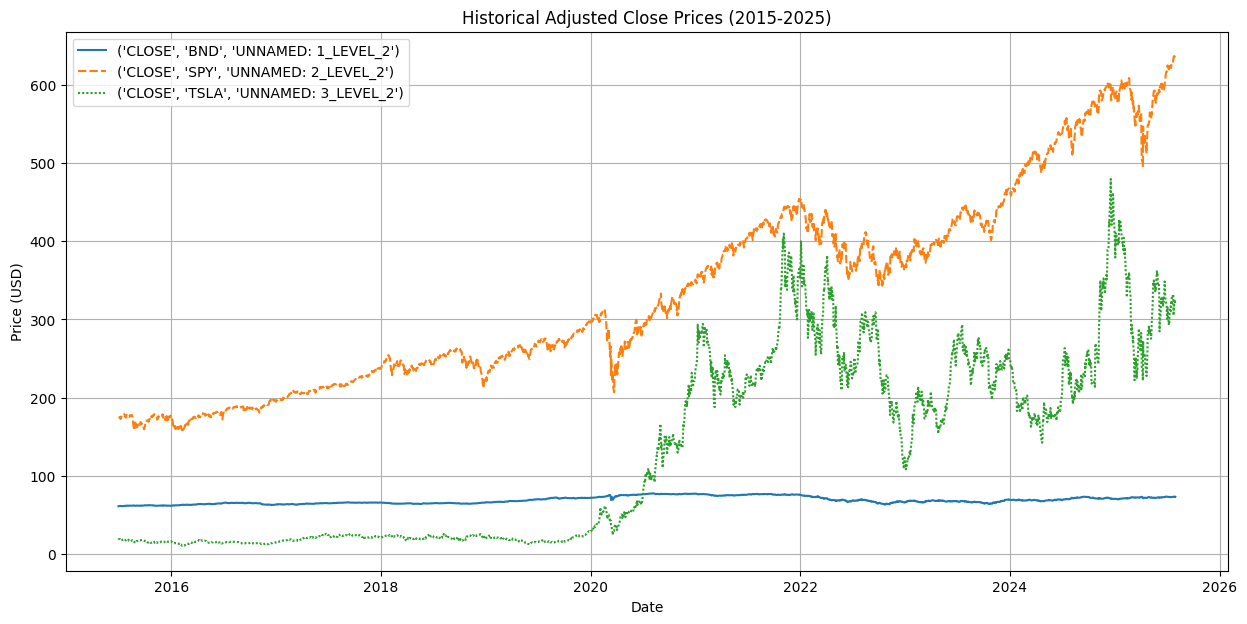

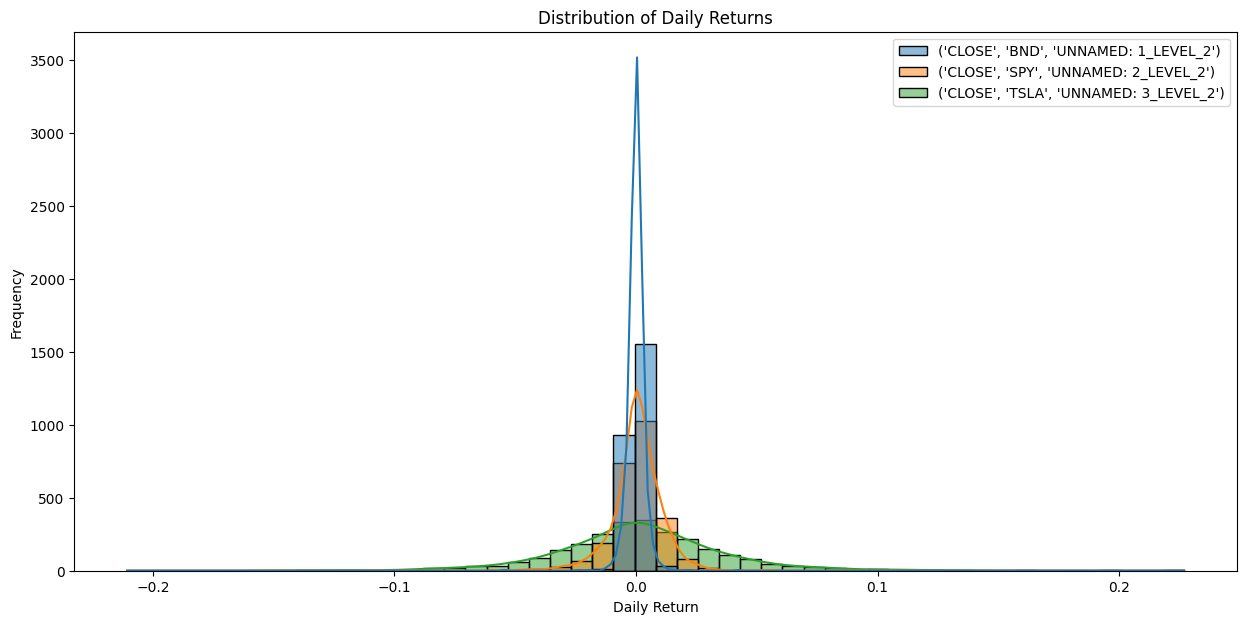

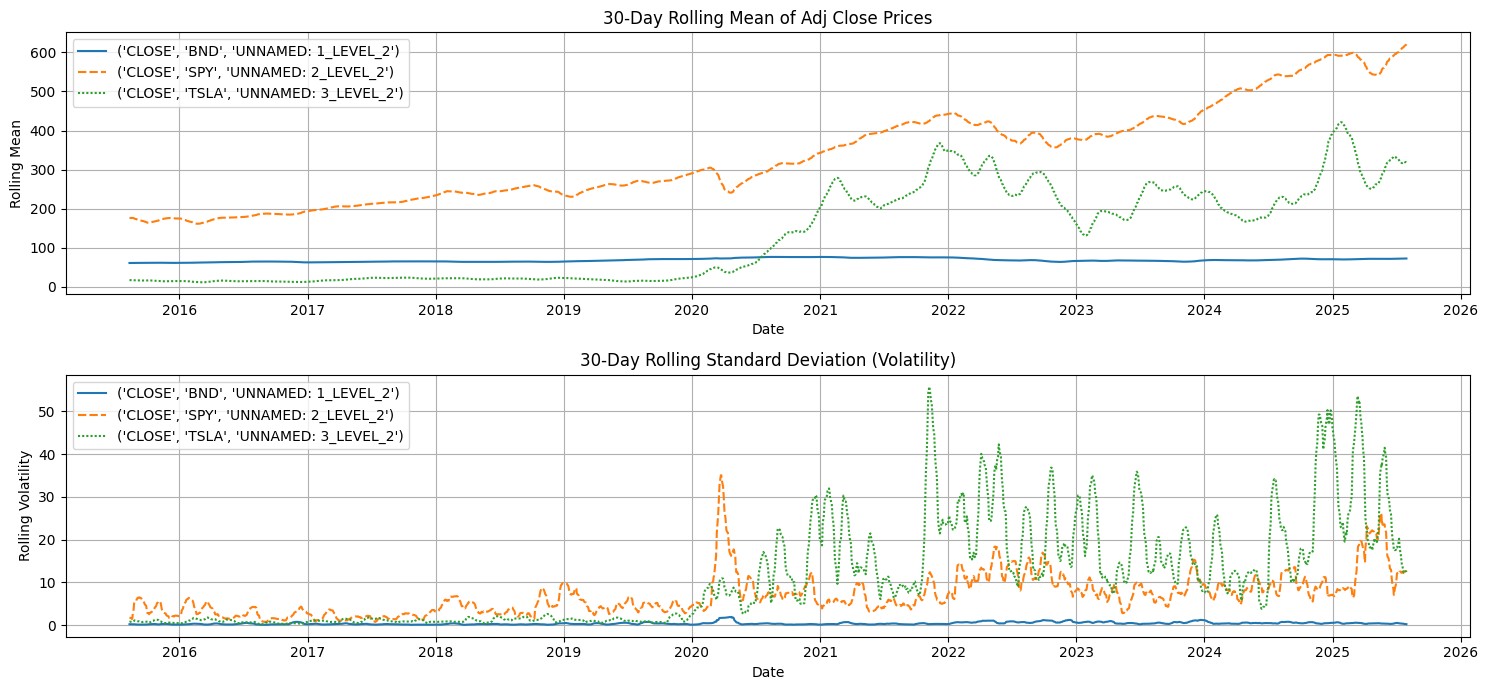


Outliers for ('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2'):
            ('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')  \
2020-03-12                               -0.054385   
2020-03-18                               -0.024140   
2020-03-17                               -0.020686   
2020-03-11                               -0.018940   
2022-06-13                               -0.016153   
...                                            ...   
2022-09-28                                0.015544   
2020-03-20                                0.016955   
2022-11-10                                0.020703   
2020-03-23                                0.022149   
2020-03-13                                0.042201   

            ('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')  \
2020-03-12                               -0.095678   
2020-03-18                               -0.050633   
2020-03-17                                0.053992   
2020-03-11                               -0.048748   
2022-06-13                 

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=data)
plt.title('Historical Adjusted Close Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.savefig('Historical Adjusted Close Prices (2015-2025).png')
plt.show()

# Calculate and plot daily returns
daily_returns = data.pct_change().dropna()
plt.figure(figsize=(15, 7))
sns.histplot(daily_returns, bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.savefig('Distribution of Daily Returns.png')
plt.show()

# Calculate and plot rolling statistics
rolling_mean = data.rolling(window=30).mean()
rolling_std = data.rolling(window=30).std()

plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
sns.lineplot(data=rolling_mean)
plt.title('30-Day Rolling Mean of Adj Close Prices')
plt.xlabel('Date')
plt.ylabel('Rolling Mean')
plt.grid(True)

plt.subplot(2, 1, 2)
sns.lineplot(data=rolling_std)
plt.title('30-Day Rolling Standard Deviation (Volatility)')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility')
plt.grid(True)
plt.tight_layout()
plt.savefig('30-Day Rolling Standard Deviation (Volatility).png')
plt.show()

# Outlier Detection - analyzing days with extreme returns
for col in daily_returns.columns:
    q1 = daily_returns[col].quantile(0.25)
    q3 = daily_returns[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = daily_returns[(daily_returns[col] < lower_bound) | (daily_returns[col] > upper_bound)]
    print(f"\nOutliers for {col}:\n{outliers.sort_values(by=col)}")

## Stationarity and risk metrics

In [ ]:
def adf_test(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n--- ADF Test for {name} ---")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print(f"Conclusion: The series is likely stationary.")
    else:
        print(f"Conclusion: The series is likely non-stationary.")

for col in data.columns:
    adf_test(data[col], f'{col} (Prices)')

for col in daily_returns.columns:
    adf_test(daily_returns[col], f'{col} (Returns)')

confidence_level = 0.95
for col in daily_returns.columns:
    var = daily_returns[col].quantile(1 - confidence_level)
    print(f"\nValue at Risk (VaR) for {col} at 95% confidence: {var:.4f}")

mean_daily_return = daily_returns.mean()
std_dev_daily_return = daily_returns.std()
risk_free_rate = 0

sharpe_ratio = (mean_daily_return - risk_free_rate) / std_dev_daily_return
annualized_sharpe = sharpe_ratio * np.sqrt(252)

print("\n--- Sharpe Ratios ---")
print(annualized_sharpe)


--- ADF Test for ('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2') (Prices) ---
ADF Statistic: -1.536253395162297
p-value: 0.5155072034488417
Critical Values: {'1%': np.float64(-3.432946577138947), '5%': np.float64(-2.8626871581881708), '10%': np.float64(-2.5673806760176046)}
Conclusion: The series is likely non-stationary.

--- ADF Test for ('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2') (Prices) ---
ADF Statistic: 0.6908120178109046
p-value: 0.9896527127671789
Critical Values: {'1%': np.float64(-3.4329424595562963), '5%': np.float64(-2.862685339846278), '10%': np.float64(-2.5673797079109892)}
Conclusion: The series is likely non-stationary.

--- ADF Test for ('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2') (Prices) ---
ADF Statistic: -1.4188720053968291
p-value: 0.5731959514207213
Critical Values: {'1%': np.float64(-3.4329610922579095), '5%': np.float64(-2.8626935681060375), '10%': np.float64(-2.567384088736619)}
Conclusion: The series is likely non-stationary.

--- ADF Test for ('CLOSE', 'BND', 'UNNAMED: 1_LEV